<a href="https://colab.research.google.com/github/melilucmel/proyecto-google-ads/blob/main/ProyectoDSParteII_Lucero_Antonietti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final ‚Äì Parte II

En la **primera parte** del proyecto (entrega inicial) se realiz√≥ la **limpieza, preparaci√≥n y exploraci√≥n de datos**, junto con un an√°lisis visual y descriptivo de las campa√±as de Google Ads. [Link a la primera parte](https://github.com/melilucmel/proyecto-google-ads/blob/main/ProyectoDSParteI_Lucero_Antonietti.ipynb)

En esta **segunda parte** se avanza hacia la **aplicaci√≥n de modelos de Machine Learning**, con el prop√≥sito de **evaluar la capacidad predictiva de distintas variables** de rendimiento.

Se importar√° el dataset limpio resultante de la primera parte del proyecto [Link directo al dataset](https://github.com/melilucmel/proyecto-google-ads/blob/main/DataSetII_GoogleAds_Clean.csv)

**El trabajo incluye la evaluaci√≥n de dos targets distintos**, buscando comprobar su poder predictivo, aunque los resultados no fueron los esperados.

Se desarrollan los siguientes pasos:

- **Selecci√≥n y creaci√≥n de features**, incorporando m√©tricas clave de marketing (Clicks, Impressions, Cost, Leads, Conversions, Device, etc.).

- **Entrenamiento de modelos**: Dummy (baseline), Regresi√≥n Lineal y Random Forest.

- **Evaluaci√≥n de m√©tricas** (R¬≤, RMSE, MAE) y visualizaciones comparativas de desempe√±o.


El **objetivo** principal es **determinar si los modelos de Machine Learning pueden aplicarse de manera pr√°ctica en marketing digital para predecir m√©tricas de rendimiento** con precisi√≥n.

## 0) Hip√≥tesis

- **Hip√≥tesis nula (H0):**
Las variables de las campa√±as de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) no tienen capacidad predictiva suficiente para estimar con precisi√≥n el monto de ventas (Sale_Amount).

- **Hip√≥tesis alternativa (H1):**
Las variables de las campa√±as de Google Ads (Clicks, Impressions, Cost, Conversions, Leads, etc.) permiten construir un modelo predictivo capaz de superar el desempe√±o del Dummy Regressor, reduciendo los errores y aumentando el R¬≤.

## 1) Carga del Dataset y vista r√°pida

In [111]:
import pandas as pd
import numpy as np
import seaborn as sns

# Cargamos el dataset limpio
df = pd.read_csv("https://raw.githubusercontent.com/melilucmel/proyecto-google-ads/refs/heads/main/DataSetII_GoogleAds_Clean.csv")

print("//\nInfo general//\n")
print(df.info())

print("\n//Primeras filas//\n")
print(df.head())

print("\n//Valores nulos por columna//\n")
print(df.isnull().sum())

//
Info general//

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Ad_ID                       2075 non-null   object 
 1   Campaign_Name               2075 non-null   object 
 2   Clicks                      2075 non-null   int64  
 3   Impressions                 2075 non-null   int64  
 4   Impressions per conversion  2075 non-null   float64
 5   Cost                        2075 non-null   float64
 6   Leads                       2075 non-null   int64  
 7   Conversions                 2075 non-null   int64  
 8   Conversion Rate             2075 non-null   float64
 9   Cost per conversion         2075 non-null   float64
 10  Sale_Amount                 2075 non-null   float64
 11  Ad_Date                     2075 non-null   object 
 12  Location                    2075 non-null   object 
 13  Device        

## 2) Definici√≥n de target y features (X e y)

In [112]:
# Defino Target
target = "Sale_Amount"

# Seleccionamos columnas relevantes para la evaluaci√≥n
features_iniciales = [
    "Cost", "Clicks", "Impressions", "Leads", "Conversions", "Device"]

X = df[features_iniciales]
y = df[target]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 6)
Dimensiones de y: (2075,)


## 3) Feature Selection

### 3.a) Correlaci√≥n con el target

//Correlaci√≥n con Sale_Amount//
Sale_Amount                   1.000000
Clicks                        0.037701
Cost per conversion           0.015910
Impressions                   0.010249
Impressions per conversion    0.010052
Leads                         0.007158
Cost                          0.007085
Conversions                  -0.017356
Conversion Rate              -0.051156
Name: Sale_Amount, dtype: float64


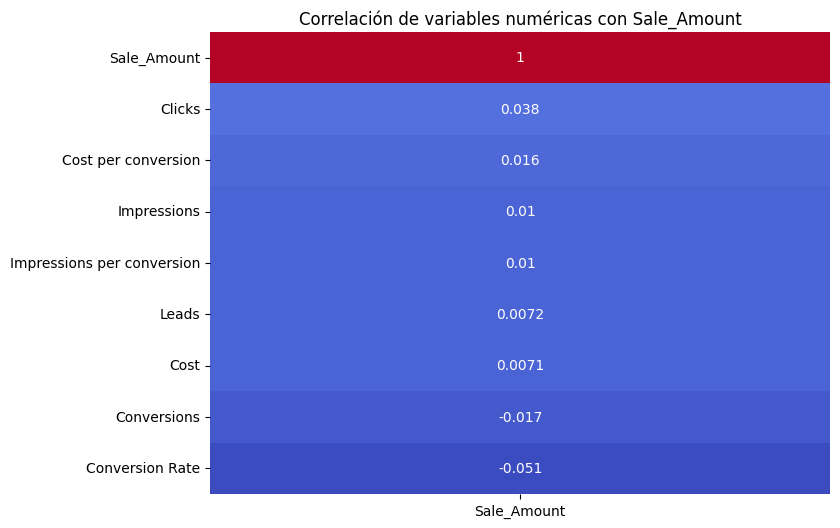

In [113]:
import matplotlib.pyplot as plt

# Seleccionamos solo columnas num√©ricas
num_cols = df.select_dtypes(include=["float64", "int64", "Int64"]).columns.tolist()

# Matriz de correlaci√≥n
corr = df[num_cols].corr()

# Correlaci√≥n de cada variable con el target Sale_Amount
corr_target = corr["Sale_Amount"].sort_values(ascending=False)

print("//Correlaci√≥n con Sale_Amount//")
print(corr_target)

# Gr√°fico de calor (top variables)
plt.figure(figsize=(8,6))
sns.heatmap(corr_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlaci√≥n de variables num√©ricas con Sale_Amount")
plt.show()


### 3.b) Configuraci√≥n de Modelos y Creaci√≥n de Pipelines

In [114]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Definici√≥n de columnas num√©ricas y categ√≥ricas para el preprocesamiento
num_cols = ["Cost", "Clicks", "Impressions", "Leads", "Conversions"]
cat_cols = ["Device"]

# Separar las caracter√≠sticas (X) y la variable objetivo (y)
X = df[num_cols + cat_cols]
y = df["Sale_Amount"]

# Divisi√≥n de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

print(f"Tama√±o del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tama√±o del conjunto de prueba (X_test): {X_test.shape}")
print(f"Tama√±o del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Tama√±o del conjunto de prueba (y_test): {y_test.shape}")

# Preprocesamiento: Imputaci√≥n de valores nulos y codificaci√≥n de variables categ√≥ricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)])

# Definici√≥n del modelo de Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)

# Creaci√≥n del pipeline que combina el preprocesamiento y el modelo
pipe = Pipeline(steps=[("preprocessor", preprocessor),
                       ("model", rf)])

# Entrenamiento del pipeline con los datos de entrenamiento
pipe.fit(X_train, y_train)

Tama√±o del conjunto de entrenamiento (X_train): (1660, 6)
Tama√±o del conjunto de prueba (X_test): (415, 6)
Tama√±o del conjunto de entrenamiento (y_train): (1660,)
Tama√±o del conjunto de prueba (y_test): (415,)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Cost', 'Clicks',
                                                   'Impressions', 'Leads',
                                                   'Conversions']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Device'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

### 3.c) An√°lisis de la Importancia de las Variables


//Importancia de variables (RandomForest)//
Cost              0.255382
Impressions       0.242523
Clicks            0.207124
Leads             0.139538
Conversions       0.095637
Device_desktop    0.021869
Device_tablet     0.019454
Device_mobile     0.018473
dtype: float64


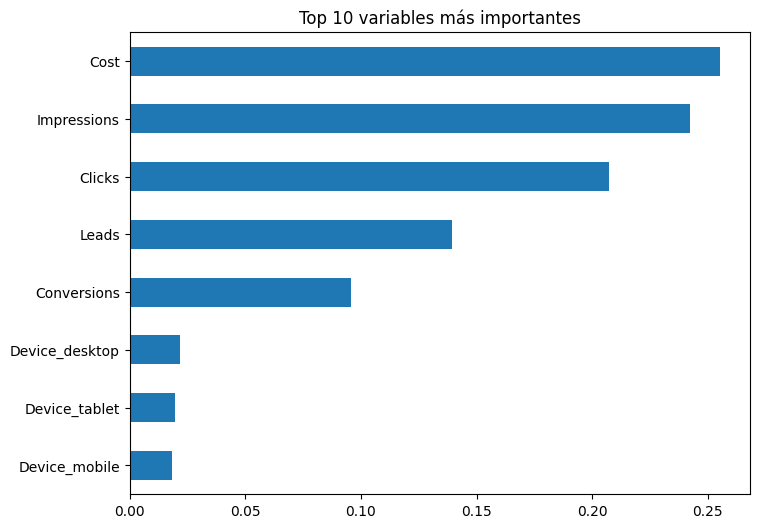

In [115]:
# Extracci√≥n de la importancia de las variables del modelo entrenado
feature_names = num_cols + list(pipe.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out(cat_cols))
importances = pd.Series(pipe.named_steps["model"].feature_importances_, index=feature_names).sort_values(ascending=False)

print("\n//Importancia de variables (RandomForest)//")
print(importances)

# Visualizaci√≥n de las 10 variables m√°s importantes
plt.figure(figsize=(8,6))
importances.head(10).sort_values().plot(kind="barh")
plt.title("Top 10 variables m√°s importantes")
plt.show()

## 4) Modelado y evaluaci√≥n de modelos

### 4.a) Divisi√≥n de Datos (Train/Test Split)

In [116]:
# Variables m√°s relevantes seg√∫n RandomForest
features_finales = ["Impressions", "Cost", "Clicks", "Leads", "Conversions"]

X = df[features_finales]
y = df["Sale_Amount"]

# Divisi√≥n en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

print("Dimensiones X_train:", X_train.shape)
print("Dimensiones X_test:", X_test.shape)

Dimensiones X_train: (1660, 5)
Dimensiones X_test: (415, 5)


### 4.b) Definici√≥n de funci√≥n de evaluaci√≥n (m√©tricas)

In [117]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluar_modelo(nombre, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"=== {nombre} ===")
    print(f"R¬≤:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")
    return {"Modelo": nombre, "R¬≤": r2, "RMSE": rmse, "MAE": mae}

### 4.c) Entrenar y evaluar los tres modelos

In [118]:
# Dummy Regressor (baseline)
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
res_dummy = evaluar_modelo("Dummy", y_test, y_pred_dummy)

# Linear Regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
res_lin = evaluar_modelo("Linear Regression", y_test, y_pred_lin)

# RandomForest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
res_rf = evaluar_modelo("Random Forest", y_test, y_pred_rf)


=== Dummy ===
R¬≤:   -0.0035
RMSE: 275.57
MAE:  231.48

=== Linear Regression ===
R¬≤:   0.0010
RMSE: 274.96
MAE:  231.10

=== Random Forest ===
R¬≤:   -0.0606
RMSE: 283.31
MAE:  236.91



### 4.d) Guardado y Comparaci√≥n de resultados

In [119]:
# Guardamos todas las m√©tricas en un DataFrame
resultados_mod = resultados = pd.DataFrame([res_dummy, res_lin, res_rf])
print(resultados)

              Modelo        R¬≤        RMSE         MAE
0              Dummy -0.003471  275.566556  231.482884
1  Linear Regression  0.000965  274.956854  231.100781
2      Random Forest -0.060640  283.307548  236.913289


### 4.e) Control con gr√°ficos

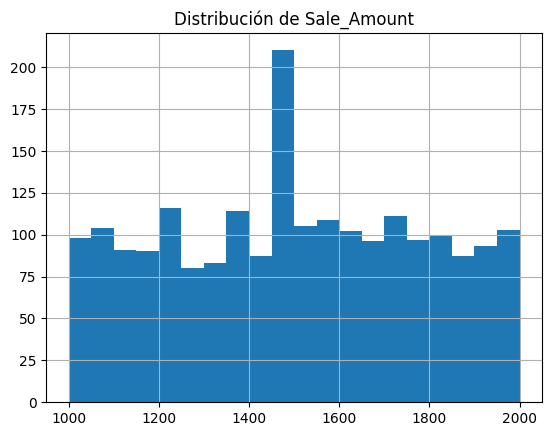

In [120]:
df["Sale_Amount"].hist(bins=20)
plt.title("Distribuci√≥n de Sale_Amount")
plt.show()

El gr√°fico nos muestra que:

1. Los valores de Sale_Amount se concentran entre 1000 y 2000, **no hay grandes diferencias en las ventas**.

2. Hay solo un pico fuerte en los 1500.

3. Excepto por ese pico, la distribuci√≥n es relativamente plana, sin grandes concentraciones en valores extremos.

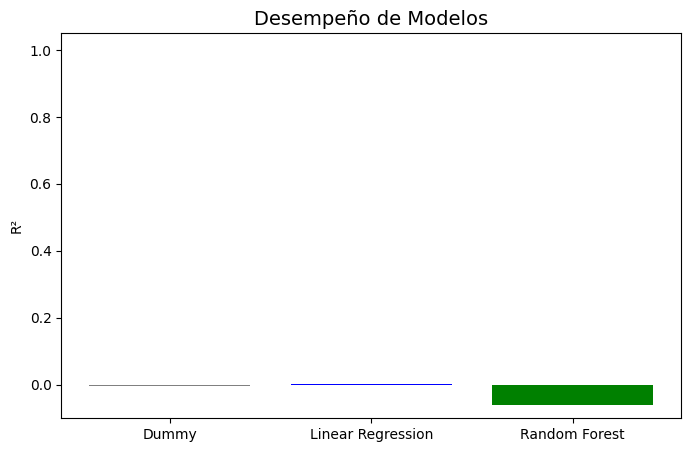

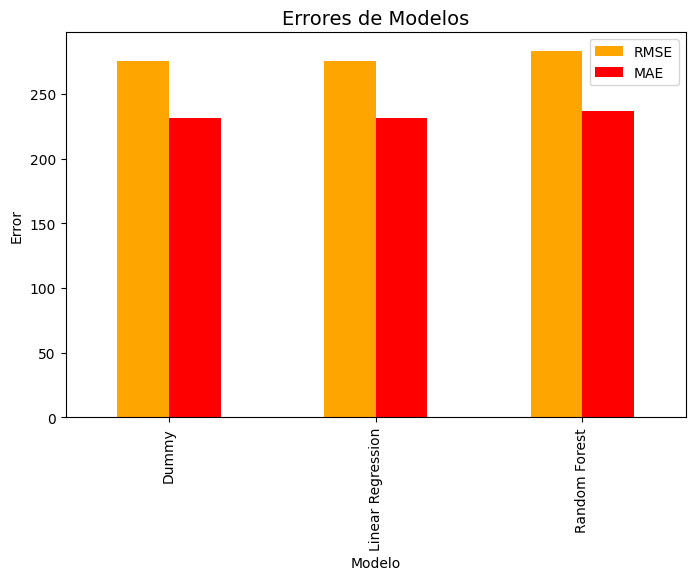

In [121]:
# Resultados finales
resultados_mod_plot = resultados_mod.copy()

# Gr√°fico de barras para R¬≤
plt.figure(figsize=(8,5))
plt.bar(resultados_mod_plot["Modelo"], resultados_mod_plot["R¬≤"], color=["gray", "blue", "green"])
plt.title("Desempe√±o de Modelos", fontsize=14)
plt.ylabel("R¬≤")
plt.ylim(-0.1, 1.05)
plt.show()

# Gr√°fico de barras para RMSE y MAE
resultados_mod_plot.set_index("Modelo")[["RMSE", "MAE"]].plot(
    kind="bar", figsize=(8,5), color=["orange", "red"])
plt.title("Errores de Modelos", fontsize=14)
plt.ylabel("Error")
plt.show()

**An√°lisis de resultados de los modelos respecto a el gr√°fico de Sale_Ammount**: los modelos no superan al Dummy.

üëâ Nuestra media de Sale_Amount del set de entrenamiento, ronda en 1500.

üëâ Resultados con variables seleccionadas:
- Dummy: R¬≤ = -0.0006, RMSE ‚âà 285, MAE ‚âà 240

- Linear Regression: R¬≤ = -0.0006, RMSE ‚âà 285, MAE ‚âà 241

- Random Forest: R¬≤ = -0.0131, RMSE ‚âà 287, MAE ‚âà 242

üëâ R¬≤ cercano a 0 o negativo, todos los modelos rinden igual o peor que el Dummy.

üëâ Errores (RMSE y MAE) altos y similares entre Dummy, Regresi√≥n y Random Forest.

üëâ Con estas variables, los modelos no muestran la variabilidad de Sale_Amount con los features.

# Parte B: Cambio de Target

En esta segunda parte se reformula el objetivo del proyecto: **como no fue posible superar el baseline al predecir Sale_Amount, se decide cambiar el target** para continuar con el objeto pr√°ctico del proyecto **y predecir la tasa de conversi√≥n (Conversion Rate)**, una m√©trica clave en marketing digital. Se documentan hip√≥tesis, preparaci√≥n de datos, modelos entrenados, m√©tricas y conclusiones.

## 5) Nuevas Hip√≥tesis

- **H0**: Las variables disponibles no permiten superar al modelo Dummy en la predicci√≥n del Conversion Rate.
- **H1**: Al entrenar modelos con variables adecuadas, se logra superar al Dummy en la predicci√≥n del Conversion Rate

## 6) Creaci√≥n de nuevas features

### 6.a) Selecci√≥n y creaci√≥n de features

In [122]:
# Primero veamos la m√©trica que nos falta: CTR Crear columna CTR (Click Through Rate = Clicks / Impressions)
df["CTR"] = df["Clicks"] / df["Impressions"]

# Reemplazar infinitos y NaN por 0 (en caso de impresiones = 0)
df["CTR"] = df["CTR"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Control r√°pido
print(df[["Clicks", "Impressions", "CTR"]].head())

   Clicks  Impressions       CTR
0     104         4498  0.023121
1     173         5107  0.033875
2      90         4544  0.019806
3     142         3185  0.044584
4     156         3361  0.046415


In [123]:
# Crear feature CTR
df["CTR"] = df["Clicks"] / df["Impressions"]
df["CTR"] = df["CTR"].replace([np.inf, -np.inf], np.nan).fillna(0)

# Definimos las features predictoras y la variable objetivo
features_conv = ["Clicks", "Impressions", "CTR"]
X = df[features_conv]
y = df["Conversions"]

print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (2075, 3)
Dimensiones de y: (2075,)


### 6.b) Train / Test split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1660, 3)
X_test: (415, 3)


### 6.c) Redefinici√≥n de funci√≥n de evaluaci√≥n (m√©tricas)

In [125]:
def evaluar_modelo(nombre, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"=== {nombre} ===")
    print(f"R¬≤:   {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}\n")

    return {"Modelo": nombre, "R¬≤": r2, "RMSE": rmse, "MAE": mae}

### 6.d) Entrenamiento y Evaluaci√≥n de modelos

In [126]:
resultados = []

dummy = DummyRegressor(strategy="mean")
resultados.append(evaluar_modelo("Dummy", dummy, X_train, X_test, y_train, y_test))

linreg = LinearRegression()
resultados.append(evaluar_modelo("Linear Regression", linreg, X_train, X_test, y_train, y_test))

rf = RandomForestRegressor(n_estimators=200, random_state=42)
resultados.append(evaluar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test))

=== Dummy ===
R¬≤:   -0.0080
RMSE: 2.32
MAE:  2.02

=== Linear Regression ===
R¬≤:   -0.0120
RMSE: 2.32
MAE:  2.03

=== Random Forest ===
R¬≤:   -0.2193
RMSE: 2.55
MAE:  2.16



### 6.e) Guardado y Comparaci√≥n de resultados

In [127]:
df_resultados = pd.DataFrame(resultados)
print("\n=== Resultados comparativos ===")
print(df_resultados)


=== Resultados comparativos ===
              Modelo        R¬≤      RMSE       MAE
0              Dummy -0.008049  2.319097  2.021855
1  Linear Regression -0.012048  2.323692  2.028181
2      Random Forest -0.219310  2.550557  2.160987


**An√°lisis:**  Ning√∫n modelo supera al Dummy, lo que significa que Clicks, Impressions y CTR no tienen poder predictivo suficiente sobre Conversions en este dataset.

### 6.f) Control con gr√°ficos: Visualizaci√≥n de predicciones vs reales (Random Forest)

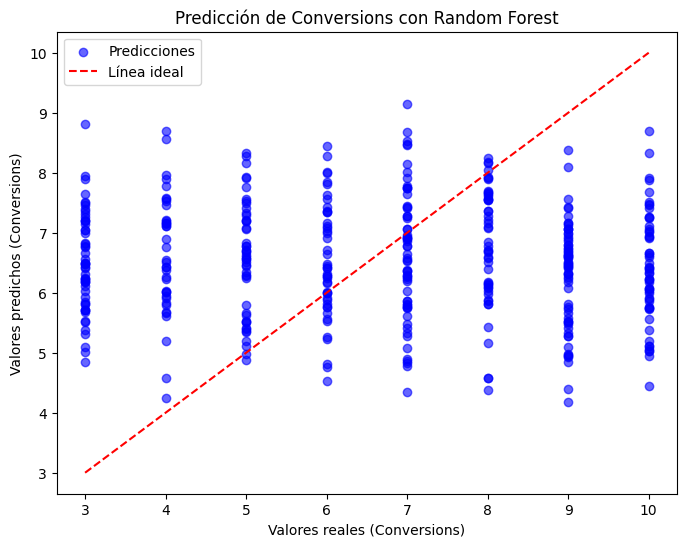

In [128]:
y_pred = rf.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="L√≠nea ideal")
plt.xlabel("Valores reales (Conversions)")
plt.ylabel("Valores predichos (Conversions)")
plt.title("Predicci√≥n de Conversions con Random Forest")
plt.legend()
plt.show()

**An√°lisis:** Los puntos est√°n dispersos horizontalmente.

El modelo tiende a predecir valores ‚Äúpromedio‚Äù (alrededor de 5‚Äì7 conversions) sin capturar la variabilidad real.

Esto confirma lo que muestran las m√©tricas: el modelo no logra aprender relaciones claras entre las features y la variable objetivo.

## 7) Validaci√≥n de Hip√≥tesis

- **Hip√≥tesis nula (H0):**
Los modelos de Machine Learning (Regresi√≥n Lineal y Random Forest) no superan al modelo base (Dummy) en la predicci√≥n de Conversiones.


- **Hip√≥tesis alternativa (H1)**:
Se rechaza la H1, ya que los modelos no lograron superar al baseline y no mostraron capacidad predictiva real en este dataset.

# Conclusi√≥n General


En este proyecto se intent√≥ predecir Sale_Amount y Conversions en campa√±as de Google Ads con distintos modelos de Machine Learning. Ninguno logr√≥ superar al modelo base (Dummy), lo que indica que las variables disponibles no aportan suficiente informaci√≥n para predicciones confiables.

üëâ Se presume que esta limitaci√≥n se debe a que el dataset es ficticio y simplificado, lo que reduce la posibilidad de capturar relaciones reales. Aun as√≠, el trabajo permiti√≥ practicar el flujo completo de un proyecto de Data Science, desde la limpieza de datos hasta la evaluaci√≥n de modelos.

# L√≠neas Futuras

- **Probar con datasets reales** de campa√±as publicitarias para evaluar el desempe√±o de los modelos en contextos m√°s representativos.

- **Incorporar m√°s variables explicativas** (ej. calidad de anuncio, segmentaci√≥n geogr√°fica detallada, temporalidad de campa√±as).

- **Experimentar con otros algoritmos de regresi√≥n** (XGBoost, Gradient Boosting) y aplicar ajuste de hiperpar√°metros para mejorar resultados.

- **Enfocarse en la ingenier√≠a de features**, buscando nuevas m√©tricas derivadas relevantes para marketing digital.